# Image Classification with Deep Learning Project #4

* Student name: ***Aysu Erdemir***
* Student pace: ***Flex***
* Scheduled project review date/time: ***January, 2023***
* Instructor name: ***Abhineet Kulkarni***

### Overview:
- A radiology department at "Be Well Healthcare Center' is interested in decreasing the work load of its radiologists by hiring a data scientist to develop a machine learning model to screen chest x-ray images and automatically mark those with pneumonia. 

- My goal is to build a Neural Network model to classify chest x-ray images as belonging to one of the two categoies: pneumonia and normal. My main purpose was to make predictions as accurately as possible while maximizing the number of True Positives (recall) and minimizing False Negatives, so that we catch as many people as possible with pneumonia (at the expense of marking some healthy people with pneumonia). 

### Data Understanding:
The data was obtained from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). 
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

### Modeling:
1. The data was re-split into training, test and val sets using different ratios: 80% for train, 10% for validation and 10% for the test set.
2. The data was pre-processed, specifically the images were re-scaled and standardized. 
3. Several versions of neural networks were built, tuned and validated:

    - Artificial Neural Network ANN 
    - Convolutional Neural Network CNN
    - Transfer Learning with VGG16
    - Transfer Learning with ResNest50V2

### Evaluation:
4. Accuracy was used as the scoring metric for tuning hyperparameters and recall was used for evaluating model performance. Whilst we would prefer an overall higher accuracy, our focus is on recall as this metric is particularly important for patient safety and to minimize the legal risk.

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import seaborn as sns
import math

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from tensorflow import keras
from keras import layers
from keras import models
from keras import optimizers
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.wrappers import scikit_learn
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

import os

In [2]:
# Making sure we work on CPU
# You can set environment variables in the notebook using os.environ. Do the following before initializing TensorFlow to limit TensorFlow to first GPU.
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# We can double check that you have the correct devices visible to TF
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4501809664287625133
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11577076303327785871
physical_device_desc: "device: XLA_CPU device"
]


# Data Visualization

In [3]:
# specify the local directory of train, validation and test data:
train_dir = "Data/chest_xray/train/"
val_dir = "Data/chest_xray/val/"
test_dir ="Data/chest_xray/test/" 

### Display the first image with pneumonia from the train dataset:

In [4]:
os.listdir("Data/chest_xray/train/PNEUMONIA")[0]

'person63_bacteria_306.jpeg'

Image Shape: (736, 1048, 3)
Max pixel: 255.0
Min pixel: 0.0
Image: [[[210. 210. 210.]
  [208. 208. 208.]
  [206. 206. 206.]
  ...
  [213. 213. 213.]
  [215. 215. 215.]
  [216. 216. 216.]]

 [[210. 210. 210.]
  [208. 208. 208.]
  [206. 206. 206.]
  ...
  [213. 213. 213.]
  [216. 216. 216.]
  [217. 217. 217.]]

 [[210. 210. 210.]
  [208. 208. 208.]
  [205. 205. 205.]
  ...
  [213. 213. 213.]
  [216. 216. 216.]
  [218. 218. 218.]]

 ...

 [[ 16.  16.  16.]
  [ 15.  15.  15.]
  [ 14.  14.  14.]
  ...
  [ 47.  47.  47.]
  [ 47.  47.  47.]
  [ 47.  47.  47.]]

 [[ 16.  16.  16.]
  [ 15.  15.  15.]
  [ 14.  14.  14.]
  ...
  [ 46.  46.  46.]
  [ 46.  46.  46.]
  [ 46.  46.  46.]]

 [[ 16.  16.  16.]
  [ 15.  15.  15.]
  [ 14.  14.  14.]
  ...
  [ 46.  46.  46.]
  [ 46.  46.  46.]
  [ 46.  46.  46.]]]


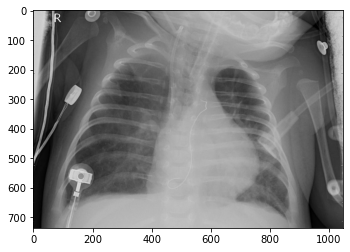

In [5]:
filename = 'Data/chest_xray/train/PNEUMONIA/person63_bacteria_306.jpeg'
sample_img = image.load_img(filename)
img_array = image.img_to_array(sample_img)  # converts image into a numpy array

print(f"Image Shape: {img_array.shape}")  # width and height
print(f"Max pixel: {img_array.max()}")
print(f"Min pixel: {img_array.min()}")
print(f"Image: {img_array}")

# Display the image
plt.imshow(sample_img, cmap='gray'); # plt.imshow(img_array.astype('uint8'))

# another way to open image: 
# from PIL import Image
# img = Image.open(filename)

In [6]:
# e.g. show RGB for 48th row, 454th column
img_array[48][454]
# RGBs are all the same

array([141., 141., 141.], dtype=float32)

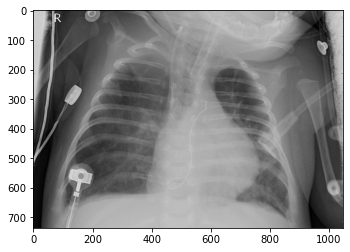

In [7]:
# reduce the 3 dimensions (RGB) into one dimension (only R):
oneDim_image = img_array[:,:,0] 
plt.imshow(oneDim_image.astype('uint8'), cmap='gray')
# same image as above, there is no color contribution. 

* The dimensions of the image are 1048 pixels width and 736 pixels height.
* Coded as RGB color mode although the raw image is grayscale and the pixels repeat.
* The maximum pixel value is 255 and the minimum is 0.

### Visualize the first 4 normal and 4 pneunomia x-rays:

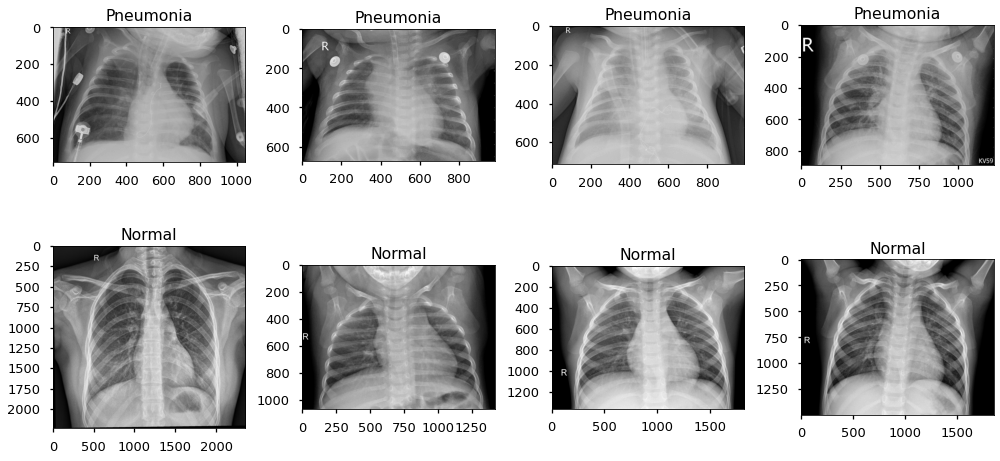

In [8]:
# Specify the set of images inside pnemonia and normal 
pneumonia = os.listdir("Data/chest_xray/train/PNEUMONIA")
normal = os.listdir("Data/chest_xray/train/NORMAL")

# Specify the location of the files = the directory
pneumonia_dir = "Data/chest_xray/train/PNEUMONIA"
normal_dir = "Data/chest_xray/train/NORMAL"

# Show the first four pictures from the train set of X-rays with and with/o Pneumonia 

with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(2, 4, figsize=(14,7))  
    for i in range(4):
        # Combine the image directory with the specific jpeg to be able to locate it
        # Read the image into an array.
        img_pneumonia = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
        img_normal = plt.imread(os.path.join(normal_dir, normal[i]))

        # Display the image
        ax[0,i].imshow(img_pneumonia, cmap = 'gray')
        ax[1,i].imshow(img_normal, cmap = 'gray')
        
        # ax[0,i].set_axis_off()
        # ax[1,i].set_axis_off()
            
        ax[0,i].set_title("Pneumonia")
        ax[1,i].set_title("Normal")

plt.tight_layout()
plt.savefig('./images/RawImages', dpi=300, bbox_inches='tight')

* The normal chest X-ray (bottom panel) seem to depict more clear lungs without any areas of abnormal opacification.
* The chest X-ray (top panel) with pneumonia seem to depict less clear lungs with some areas of opacification/consolidation.

### What is total number of normal and pneumonia images in the train-test-val sets?

Train Pneumomia: 3876
Train Normal: 1342
-------------------
Test Pneumomia: 390
Test Normal: 234
--------------------
Val Pneumomia: 9
Val Normal: 9
--------------------
Train Images Percentage: 0.89
Test Images Percentage: 0.106
Val Images Percentage: 0.003


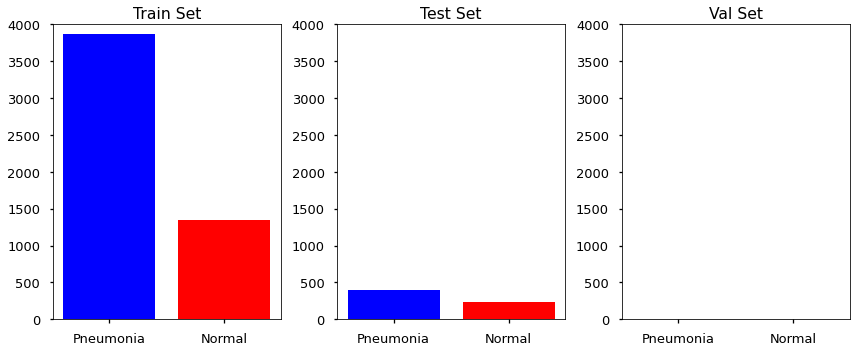

In [9]:
# Specify the set of images inside pnemonia and normal for train, test, val sets:
num_pneumonia_train = (len(os.listdir("Data/chest_xray/train/PNEUMONIA")) ) 
num_normal_train = (len(os.listdir("Data/chest_xray/train/NORMAL")) )
                       
num_pneumonia_test = (len(os.listdir("Data/chest_xray/test/PNEUMONIA")) )
num_normal_test = (len(os.listdir("Data/chest_xray/test/NORMAL")) )
      
num_pneumonia_val = (len(os.listdir("Data/chest_xray/val/PNEUMONIA")) )
num_normal_val = (len(os.listdir("Data/chest_xray/val/NORMAL")))
                             
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    ax1.bar(x = ["Pneumonia","Normal"], height=[num_pneumonia_train, num_normal_train], color=["blue", "red"])
    ax1.set_title('Train Set')
    ax2.bar(x = ["Pneumonia","Normal"], height=[num_pneumonia_test, num_normal_test], color=["blue", "red"])
    ax2.set_title('Test Set')
    ax3.bar(x = ["Pneumonia","Normal"], height=[num_pneumonia_val, num_normal_val], color=["blue", "red"]) 
    ax3.set_title('Val Set')
    
    ax1.set_ylim([0, 4000])
    ax2.set_ylim([0, 4000])
    ax3.set_ylim([0, 4000])
    plt.tight_layout()
    
print(f"Train Pneumomia: {num_pneumonia_train}")
print(f"Train Normal: {num_normal_train}")
print("-------------------")
print(f"Test Pneumomia: {num_pneumonia_test}")
print(f"Test Normal: {num_normal_test}")
print("--------------------")
print(f"Val Pneumomia: {num_pneumonia_val}")
print(f"Val Normal: {num_normal_val}")
print("--------------------")
          
TrainTotal = num_pneumonia_train + num_normal_train
TestTotal = num_pneumonia_test + num_normal_test
ValTotal = num_pneumonia_val + num_normal_val
Total = TrainTotal + TestTotal + ValTotal
print(f"Train Images Percentage: {np.round((TrainTotal / Total),3) }")
print(f"Test Images Percentage: {np.round((TestTotal / Total),3) }")
print(f"Val Images Percentage: {np.round((ValTotal / Total),3) }")


* Number of images in the **validation** set appears too low with a total of 18 images and total percentage of **.3%**. We need to boost it to at about 10%. 
* Number of images in the **test** set appears ideal with a total percentage of **10%**. 
* Number of images in the **train** set is good with a total percentage of **89%**, but we will move some of the images from train to the validation set to boost the numbers in the val set. 80% is sufficient for the train set.  

### Change the size of the Train-Test-Val sets:
* Using splitfolders package (https://pypi.org/project/split-folders/)
* Split the data in the folder **"Data/INPUT"** with **"Pneumonia" and "Normal"** subfolders into the output folder **"Data/OUTPUT"** with **"train","test","val"** subfolders using the pre-specified percentages.

In [10]:
# !pip install split-folders
import splitfolders

# Change the size of Train, Test and Val sets with ratios: .81, .09, .1. 
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("Data/INPUT", output="Data/OUTPUT",
    seed=1337, ratio=(.81, .09, .1), group_prefix=None, move=False) # default values

Copying files: 5856 files [00:10, 567.40 files/s]


### What is total number of normal and pneumonia images in the NEW train-test-val sets?

Train Pneumomia: 3461
Train Normal: 1282
-------------------
Test Pneumomia: 428
Test Normal: 159
--------------------
Val Pneumomia: 384
Val Normal: 142
--------------------
Train Images Percentage: 0.81
Test Images Percentage: 0.1
Val Images Percentage: 0.09


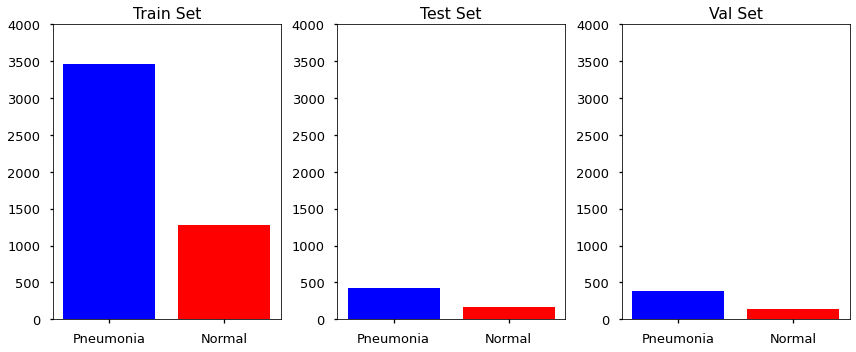

In [11]:
num_pneumonia_train = (len(os.listdir("Data/OUTPUT/train/PNEUMONIA")) ) 
num_normal_train = (len(os.listdir("Data/OUTPUT/train/NORMAL")) )
                       
num_pneumonia_test = (len(os.listdir("Data/OUTPUT/test/PNEUMONIA")) )
num_normal_test = (len(os.listdir("Data/OUTPUT/test/NORMAL")) )
      
num_pneumonia_val = (len(os.listdir("Data/OUTPUT/val/PNEUMONIA")) )
num_normal_val = (len(os.listdir("Data/OUTPUT/val/NORMAL")))
                             
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    ax1.bar(x = ["Pneumonia","Normal"], height=[num_pneumonia_train, num_normal_train], color=["blue", "red"])
    ax1.set_title('Train Set')
    ax2.bar(x = ["Pneumonia","Normal"], height=[num_pneumonia_test, num_normal_test], color=["blue", "red"])
    ax2.set_title('Test Set')
    ax3.bar(x = ["Pneumonia","Normal"], height=[num_pneumonia_val, num_normal_val], color=["blue", "red"]) 
    ax3.set_title('Val Set')
    
    ax1.set_ylim([0, 4000])
    ax2.set_ylim([0, 4000])
    ax3.set_ylim([0, 4000])
    plt.tight_layout()
    
print(f"Train Pneumomia: {num_pneumonia_train}")
print(f"Train Normal: {num_normal_train}")
print("-------------------")
print(f"Test Pneumomia: {num_pneumonia_test}")
print(f"Test Normal: {num_normal_test}")
print("--------------------")
print(f"Val Pneumomia: {num_pneumonia_val}")
print(f"Val Normal: {num_normal_val}")
print("--------------------")
          
TrainTotal = num_pneumonia_train + num_normal_train
TestTotal = num_pneumonia_test + num_normal_test
ValTotal = num_pneumonia_val + num_normal_val
Total = TrainTotal + TestTotal + ValTotal
print(f"Train Images Percentage: {np.round((TrainTotal / Total),3) }")
print(f"Test Images Percentage: {np.round((TestTotal / Total),3) }")
print(f"Val Images Percentage: {np.round((ValTotal / Total),3) }") 

plt.savefig('./images/ImageCounts', dpi=300, bbox_inches='tight')  

* New split looks much better with about 80% train, 10% test and 10% validation. 

In [12]:
# Specify the new location of the train, test and val images 
train_dir = "Data/OUTPUT/train/"
test_dir ="Data/OUTPUT/test/" 
val_dir = "Data/OUTPUT/val/"

# Image Preprocessing:

## Data Normalization:

* **Pixel Normalization**: For images, a common thing that is done is to make sure each pixel value is between 0 and 1. This can be done by dividing the entire matrix by 255. 

* **Size Rescaling**: Since all of the images are different sizes, we need to rescale (standardize) them using a target width and height. We will use a size of 128x128. In general, the resolutions for training CNNs usually range between 64 × 64 and 256 × 256.

* **Reshaping into tensors**: Convolutional Neural Networks takes its input as **tensors**. We will use the output from flow_from_directory() directly to feed them into the CNNs. 

* **Reshaping into vectors**: A multilayer perceptron (MLP) - fully connected atrificial Neural Network (ANN) takes its input as **vectors** (single-dimensional array), not matrices (2-D grid) or tensors (generalized matrix). So we need to reshape the images into a single 16384-dimensional vector (128x128) to feed them into the ANNs. 

In [13]:
print(f"Train Images Total#: {TrainTotal}")
print(f"Test Images Total#: {TestTotal}")
print(f"Val Images Total#: {ValTotal}")

Train Images Total#: 4743
Test Images Total#: 587
Val Images Total#: 526


### Format the data using Keras ImageDataGenerator():
* Rescale pixel values to be between 0-1.
* Rescale the size to be 128 x 128
* Reformat the target data into 1s (pneumonia) and 0s (normal) # class_mode='binary'

In [14]:
# For example, if you have 1000 images in your dataset and the batch size is defined as 10. 
# Then the "ImageDataGenerator" will produce 10 images in each iteration of the training.
# We will use the size of the whole dataset since there are no computational issues with ~5000 images. 

# Each pixel is originally between 255 and 0, Rescale the data to be between 0 and 1. 
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)

# Target Size: 128 x 128: The dimensions to which all images found will be resized:

# get the data from the training directory
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(128, 128),
                                                    batch_size=4743, # default is 32
                                                    class_mode='binary')

# get the data from the validation directory
test_generator = test_datagen.flow_from_directory(test_dir,
                                                target_size=(128, 128),
                                                batch_size=587,
                                                class_mode='binary')

# get the data from the validation directory
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(128, 128),
                                                batch_size=526,
                                                class_mode='binary')

print(train_generator.class_indices)

Found 4743 images belonging to 2 classes.
Found 587 images belonging to 2 classes.
Found 526 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


4743 divisors: 17, 31, 51, 93, 153,

In [15]:
train_generator.image_shape, test_generator.image_shape, val_generator.image_shape

((128, 128, 3), (128, 128, 3), (128, 128, 3))

### Create the transformed data sets:

#### Tensor for CNN:

In [16]:
# tensors for CNN:
# next() returns the next item in the iterator = The first batch of the images, in our case all images. 
train_image, train_label = next(train_generator)
test_image, test_label = next(test_generator)
val_image, val_label = next(val_generator)

In [17]:
print(train_image.shape)
print(train_label.shape)

(4743, 128, 128, 3)
(4743,)


In [18]:
train_image[0].shape

(128, 128, 3)

In [19]:
# display the first image tensor
train_image[0]

array([[[0.14509805, 0.14509805, 0.14509805],
        [0.16470589, 0.16470589, 0.16470589],
        [0.1764706 , 0.1764706 , 0.1764706 ],
        ...,
        [0.1254902 , 0.1254902 , 0.1254902 ],
        [0.1254902 , 0.1254902 , 0.1254902 ],
        [0.1254902 , 0.1254902 , 0.1254902 ]],

       [[0.14117648, 0.14117648, 0.14117648],
        [0.17254902, 0.17254902, 0.17254902],
        [0.17254902, 0.17254902, 0.17254902],
        ...,
        [0.12941177, 0.12941177, 0.12941177],
        [0.1254902 , 0.1254902 , 0.1254902 ],
        [0.1254902 , 0.1254902 , 0.1254902 ]],

       [[0.14117648, 0.14117648, 0.14117648],
        [0.16470589, 0.16470589, 0.16470589],
        [0.17254902, 0.17254902, 0.17254902],
        ...,
        [0.12941177, 0.12941177, 0.12941177],
        [0.1254902 , 0.1254902 , 0.1254902 ],
        [0.1254902 , 0.1254902 , 0.1254902 ]],

       ...,

       [[0.13725491, 0.13725491, 0.13725491],
        [0.13725491, 0.13725491, 0.13725491],
        [0.13333334, 0

#### Vector of ANN:
* Reshape the transformed images into vectors to be able to use them in ANN

In [20]:
# Reshape images 
# train from (4743, 128, 128, 3) to (4743, 49152)

X_train = train_image.reshape(train_image.shape[0], -1)
X_test = test_image.reshape(test_image.shape[0], -1)
X_val = val_image.reshape(val_image.shape[0], -1)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(4743, 49152)
(587, 49152)
(526, 49152)


* Reshape the transformed labels:

In [21]:
'''
Reshape labels from (4743,) array([0., 1., 0., ..., 1., 1., 1.] 
to (4743, 1)
array([[0.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]],:
'''
# Reshape labels
y_train = np.reshape(train_label, (4743,1))   # y_train2 = train_label.reshape(train_label.shape[0], 1)
y_test = np.reshape(test_label, (587,1))
y_val = np.reshape(val_label, (526,1))

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(4743, 1)
(587, 1)
(526, 1)


### Visualize some of the transformed images from the training dataset:
* The images appear in a standardized way now:

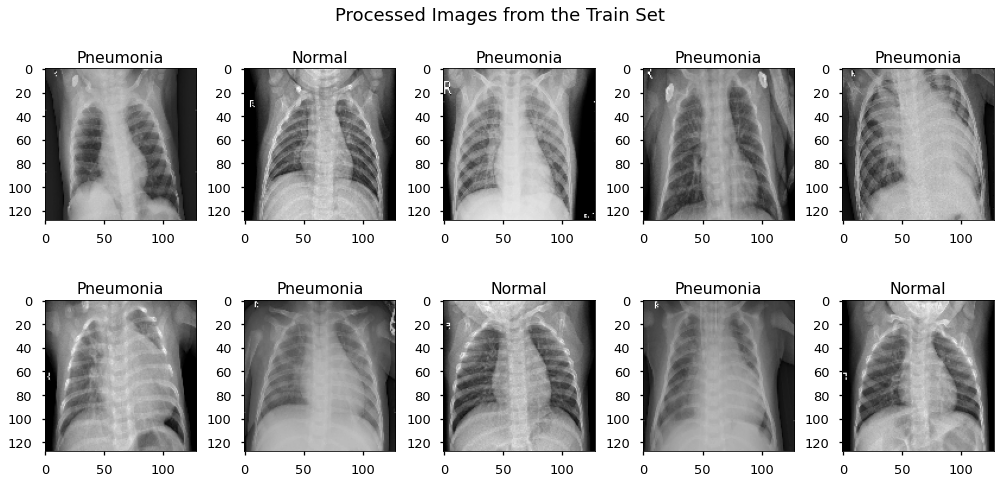

In [22]:
plt.figure(figsize=(14,7))

with plt.style.context('seaborn-talk'):
    for i in range(10):
        ax = plt.subplot(2,5,i+1) # This is object oriented and different from plt.subplots() 
        plt.imshow(train_image[i])
        if train_label[i]==0:
            plt.title("Normal")
        else:
            plt.title("Pneumonia")
        # plt.axis('off')
plt.suptitle('Processed Images from the Train Set',fontsize=18)
plt.tight_layout()
plt.savefig('./images/ProcessedImages', dpi=300, bbox_inches='tight')

# MODELING:

# Baseline Artificial Neural Network:
* One input layer with 8 neurons with relu activation which works well with images. 
* One output layer with 1 neuron for the binary classification (normal versus pneumonia). 
* Input shape is a vector with 49152 rows (128 x 128 x 3)
* Using Adam optimizer ("Adaptive Moment Estimation") an adoptive learning rate optimizer which is widely used for training deep neural networks and in image processing. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm. Learning rate defaults to 0.001 but the contribution of gradients to updated weight varies over epochs, hence ADAPTIVE. 

In [27]:
# Size of the image vector:
128*128*3

49152

In [28]:
# specify the model:
model = models.Sequential()

# Add dense layers with relu activation
model.add(layers.Dense(8, activation='relu', input_shape = (49152,))) 
# Add final layer with sigmoid activation
model.add(layers.Dense(1, activation='sigmoid'))  # because this is a binary decision task

model.compile(loss = 'binary_crossentropy',  # because this is a binary decision task
              optimizer = 'adam', 
              metrics = ['accuracy'])  # [keras.metrics.Recall()

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 393224    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 393,233
Trainable params: 393,233
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Fit model, set epochs to 31 because 4743 is divisible to 31. 
Baseline_ANN = model.fit(X_train, y_train, epochs = 100, batch_size = 31, verbose =0, 
                    validation_data = (X_val, y_val))

### Evaluate the model performance: 
* A traditional Neural Network and CNN uses different data shapes as the input images. Vector for ANN and tensor for CNN. 
* A traditional Neural Network and CNN also differ in how how accuracy metrics are reported: "accuracy" and "val_accuracy" for ANN versus "acc" and "val_acc" for CNN. 
* Therefore, we need to specify the result from the model, Xtrain, Xtest, accuracy and valaccuracy for the function below to be generalizable:

In [31]:
def visualize_model_performance(result, Xtrainname, Xtestname, accuracy, valaccuracy):
    
    with plt.style.context('seaborn-talk'):
        
        # Diplay train and validation loss and accuracy:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,5))
        ax1.plot(result.history['loss'])
        ax1.plot(result.history['val_loss'])
        ax1.set_title("Loss")
        ax1.legend(labels = ['train loss', 'val loss'])
        ax2.plot(result.history[accuracy])
        ax2.plot(result.history[valaccuracy])
        ax2.legend(labels = ['train acc', 'val acc'])
        ax2.set_title('Accuracy')

        # Output (probability) predictions for the test set 
        y_hat_test = result.model.predict(Xtestname)
        y_pred = np.rint(y_hat_test).astype(np.int) # Round elements of the array to the nearest integer.
        y_true = y_test.astype(np.int)
    
        # Generate a confusion matrix displaying the predictive accuracy of the model on the test set:
        cm = confusion_matrix(y_true, y_pred) # normalize = 'true'
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap = "Blues", ax=ax3)
        ax3.set_title('Confusion Matrix - TestSet')

        # Print Classification Report displaying the performance of the model on the test set using various metrics:
        print('Classification Report:')
        print(classification_report(y_true, y_pred))
        print('\n')

        # Print final train and test loss and accuracy:
        train_loss, train_acc = result.model.evaluate(Xtrainname, y_train);
        test_loss, test_acc = result.model.evaluate(Xtestname, y_test);
        print('--------------------------')
        print(f'Final Train Loss: {np.round(train_loss,4)}')
        print(f'Final Test Loss: {np.round(test_loss,4)}') 
        print('--------------------------')
        print(f'Final Train Acc: {np.round(train_acc,4)}')
        print(f'Final Test Acc: {np.round(test_acc,4)}') 
        print('\n')
        

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       159
           1       0.73      1.00      0.84       428

    accuracy                           0.73       587
   macro avg       0.36      0.50      0.42       587
weighted avg       0.53      0.73      0.61       587



19/19 [==============================] - 0s 1ms/step - loss: 0.5841 - accuracy: 0.7291
--------------------------
Final Train Loss: 0.5836
Final Test Loss: 0.5841
--------------------------
Final Train Acc: 0.7297
Final Test Acc: 0.7291




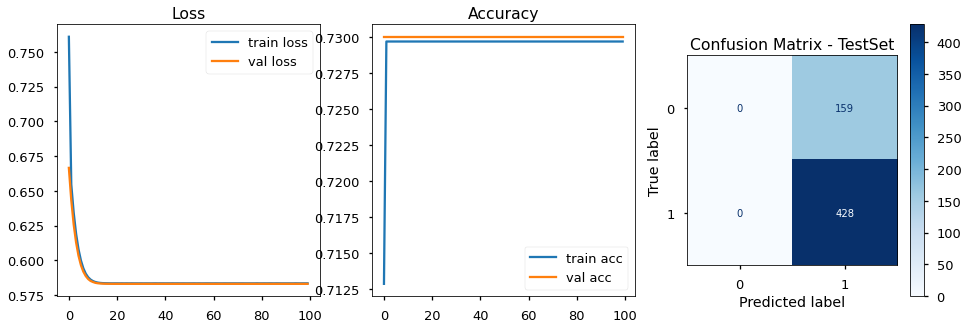

In [32]:
visualize_model_performance(Baseline_ANN, X_train, X_test, "accuracy", "val_accuracy")

* The extremely simple baseline ANN is basically predicting all x-rays as Pneumonia, which still leads to a 73% accuracy. 

# Bigger/Deeper Artificial Neural Network:
* Add an input layer with 128 meurons
* Add three hidden layers with 64, 32 and 10 neurons. 
* Add the output layer with 1 neuron. 

**Early Stopping:** Specify early stopping training  for all the subsequent models so that once the model performance stops improving on a hold out validation dataset the training will stop. It helps with overfitting and it won't run for more epochs unnecessarily: 

In [33]:
# Patience number of 10: the number of epochs to wait before early stop if no progress on the validation set. 
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [34]:
model = models.Sequential()

# Add dense layers with relu activation
model.add(layers.Dense(128, activation='relu', input_shape = (49152,)))
model.add(layers.Dense(64, activation='relu')) 
model.add(layers.Dense(32, activation='relu')) 
model.add(layers.Dense(10, activation='relu')) 

# Add final layer with sigmoid activation
model.add(layers.Dense(1, activation='sigmoid')) 

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               6291584   
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 6,302,261
Trainable params: 6,302,261
Non-trainable params: 0
_________________________________________________________________


In [36]:
Deeper_ANN = model.fit(X_train, y_train, epochs = 100, batch_size = 31, verbose = 0,
                    validation_data = (X_val, y_val), callbacks = [early_stop])

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       159
           1       0.96      0.95      0.96       428

    accuracy                           0.94       587
   macro avg       0.91      0.92      0.92       587
weighted avg       0.94      0.94      0.94       587



19/19 [==============================] - 0s 4ms/step - loss: 0.1641 - accuracy: 0.9353
--------------------------
Final Train Loss: 0.0978
Final Test Loss: 0.1641
--------------------------
Final Train Acc: 0.9629
Final Test Acc: 0.9353




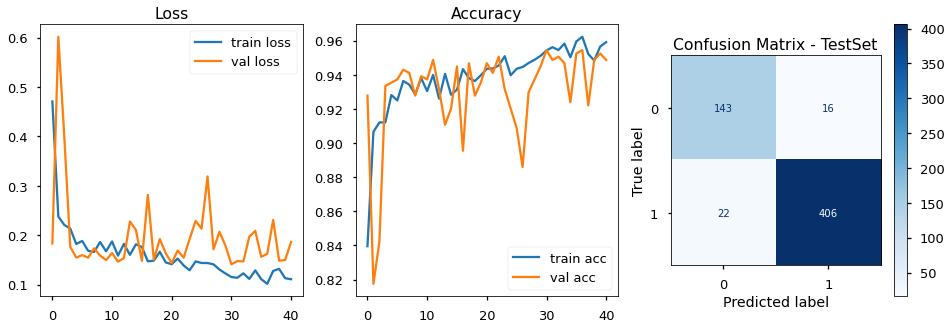

In [37]:
visualize_model_performance(Deeper_ANN, X_train, X_test, "accuracy", "val_accuracy")

* A Deeper ANN with 5 layers improves the performance extensively achieving an overall accuracy of 93% on the test set. 
* Recall for pneumonia is 95%, that is predicting true pneumonia cases as pneumonia. 22 out of 428 pneumonia cases are mislabeled as normal. 

# Deeper ANN with Class Weights (due to class inbalance):
* Using the same number of layers / neurons as above but adding class weights to see if it would improve performance. 

In [38]:
pneumonia = os.listdir("Data/OUTPUT/train/PNEUMONIA")
normal = os.listdir("Data/OUTPUT/train/NORMAL")

weight_pneumonia = len(normal)/(len(normal) + len(pneumonia))
weight_normal = len(pneumonia)/(len(normal) + len(pneumonia)) 

print(len(pneumonia), len(normal))
print(f'Weight for class pneumonia: {np.round(weight_pneumonia, 2)}')
print(f'Weight for class normal: {np.round(weight_normal, 2)}')
    

3461 1282
Weight for class pneumonia: 0.27
Weight for class normal: 0.73


In [39]:
weights_dict = {0:np.round(weight_normal, 2) , 1: np.round(weight_pneumonia, 2)}
weights_dict

{0: 0.73, 1: 0.27}

In [42]:
Weighted_ANN = model.fit(X_train, y_train, epochs = 100, batch_size = 31, verbose = 0, 
                    validation_data = (X_val, y_val), class_weight = weights_dict, callbacks = [early_stop])

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       159
           1       0.96      0.96      0.96       428

    accuracy                           0.94       587
   macro avg       0.92      0.93      0.92       587
weighted avg       0.94      0.94      0.94       587



19/19 [==============================] - 0s 4ms/step - loss: 0.1548 - accuracy: 0.9404
--------------------------
Final Train Loss: 0.0899
Final Test Loss: 0.1548
--------------------------
Final Train Acc: 0.9707
Final Test Acc: 0.9404




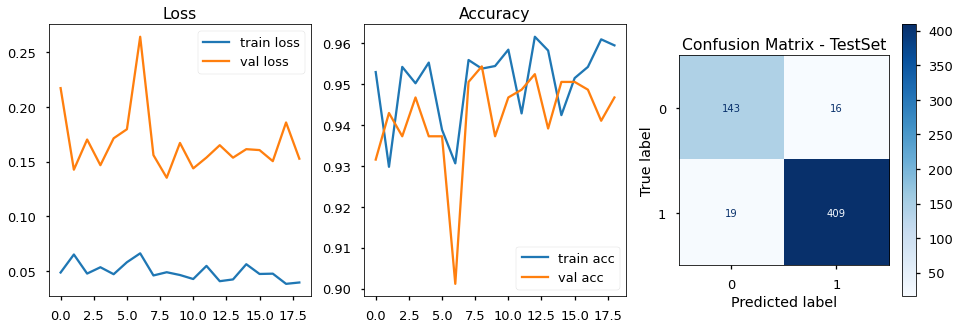

In [43]:
visualize_model_performance(Weighted_ANN, X_train, X_test, "accuracy", "val_accuracy")

* Using class weights for the Deeper ANN with 4 layers improves the performance very slightly for pneumonia cases. 
* Recall for pneumonia is now up to 96%. 19 out of 428 pneumonia cases are mislabeled as normal. 

# Baseline Convolutional Neural Network:
* Baseline model with 1 convolutional layer, 1 max pooling layer, and 1 fully connected layer
* Number of output filters in the convolutional layer is 8.
* Kernel Size is 3 x 3. If your images are smaller than 128×128 you may want to consider sticking with strictly 1×1 and 3×3 filters.
* A fully connected layer with 16 neurons. Neurons in this layer have full connectivity with all neurons in the preceding and succeeding layer as seen in regular FCNN. The FC layer helps to map the representation between the input and the output.
* An output layer with 1 neuron making the predictions. 

In [44]:
model = Sequential()

# 1st Convolution and Pooling
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(128, 128, 3))) 
model.add(MaxPool2D(pool_size = (2, 2)))  

# Flatten
model.add(Flatten())

# Include a fully-connected layer and an output layer
model.add(Dense(activation = 'relu', units = 8)) # inner layer
model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 31752)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 254024    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 254,257
Trainable params: 254,257
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Train the model
Baseline_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=31, 
                    validation_data = (val_image, y_val), callbacks = [early_stop])  

Epoch 1/100
153/153 [==============================] - 7s 46ms/step - loss: 0.6821 - acc: 0.7179 - val_loss: 0.6652 - val_acc: 0.7300
Epoch 2/100
153/153 [==============================] - 7s 48ms/step - loss: 0.6531 - acc: 0.7297 - val_loss: 0.6420 - val_acc: 0.7300
Epoch 3/100
153/153 [==============================] - 8s 50ms/step - loss: 0.6331 - acc: 0.7297 - val_loss: 0.6246 - val_acc: 0.7300
Epoch 4/100
153/153 [==============================] - 7s 49ms/step - loss: 0.6181 - acc: 0.7297 - val_loss: 0.6119 - val_acc: 0.7300
Epoch 5/100
153/153 [==============================] - 8s 50ms/step - loss: 0.6073 - acc: 0.7297 - val_loss: 0.6027 - val_acc: 0.7300
Epoch 6/100
153/153 [==============================] - 8s 50ms/step - loss: 0.5995 - acc: 0.7297 - val_loss: 0.5961 - val_acc: 0.7300
Epoch 7/100
153/153 [==============================] - 8s 49ms/step - loss: 0.5940 - acc: 0.7297 - val_loss: 0.5916 - val_acc: 0.7300
Epoch 8/100
153/153 [==============================] - 8s 52ms

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       159
           1       0.73      1.00      0.84       428

    accuracy                           0.73       587
   macro avg       0.36      0.50      0.42       587
weighted avg       0.53      0.73      0.61       587



19/19 [==============================] - 0s 14ms/step - loss: 0.5841 - acc: 0.7291
--------------------------
Final Train Loss: 0.5836
Final Test Loss: 0.5841
--------------------------
Final Train Acc: 0.7297
Final Test Acc: 0.7291




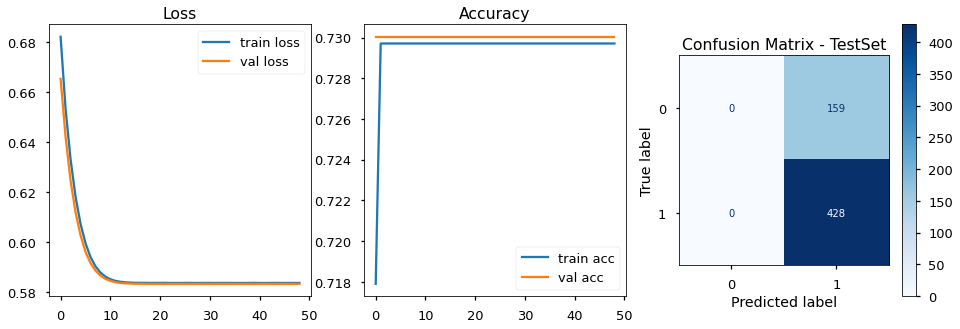

In [46]:
visualize_model_performance(Baseline_CNN, train_image, test_image, "acc", "val_acc")

* The  simplest CNN is  predicting all x-rays as Pneumonia, which still leads to a 73% accuracy such like ANN.  There are not enough layers and filters in this model to detect the visual features representing pneumonia. 

# Deeper CNN:
* I will deepen the neural network to include more layers, filters and neurons to pull more features out of the images to improve the model.
* Layers early in the network architecture (i.e., closer to the actual input image) learn fewer convolutional filters while layers deeper in the network (i.e., closer to the output predictions) will learn more filters.

In [47]:
model = Sequential()

# 1st Convolution and Pooling
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  #input_shape=(128, 128,1)
model.add(MaxPool2D(pool_size = (2, 2)))  # 32 is number of filters

# 2nd Convolution and Pooling
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size = (2, 2)))

# 3rd Convolution and Pooling
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size = (2, 2)))

# Flatten
model.add(Flatten())

# activation
model.add(Dense(activation = 'relu', units = 128)) # inner layer
model.add(Dense(activation = 'relu', units = 64)) # inner layer
model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)            

In [48]:
Deeper_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data = (val_image, y_val), callbacks = [early_stop])  

Epoch 1/100
153/153 [==============================] - 44s 288ms/step - loss: 0.3123 - acc: 0.8714 - val_loss: 0.1955 - val_acc: 0.9202
Epoch 2/100
153/153 [==============================] - 44s 288ms/step - loss: 0.1527 - acc: 0.9422 - val_loss: 0.1434 - val_acc: 0.9411
Epoch 3/100
153/153 [==============================] - 44s 289ms/step - loss: 0.1272 - acc: 0.9515 - val_loss: 0.1526 - val_acc: 0.9468
Epoch 4/100
153/153 [==============================] - 44s 285ms/step - loss: 0.1122 - acc: 0.9559 - val_loss: 0.1298 - val_acc: 0.9506
Epoch 5/100
153/153 [==============================] - 44s 285ms/step - loss: 0.1081 - acc: 0.9587 - val_loss: 0.1226 - val_acc: 0.9563
Epoch 6/100
153/153 [==============================] - 43s 283ms/step - loss: 0.1003 - acc: 0.9625 - val_loss: 0.1407 - val_acc: 0.9449
Epoch 7/100
153/153 [==============================] - 47s 305ms/step - loss: 0.0883 - acc: 0.9667 - val_loss: 0.1179 - val_acc: 0.9601
Epoch 8/100
153/153 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       159
           1       0.98      0.96      0.97       428

    accuracy                           0.95       587
   macro avg       0.94      0.95      0.94       587
weighted avg       0.96      0.95      0.95       587



19/19 [==============================] - 1s 61ms/step - loss: 0.1111 - acc: 0.9540
--------------------------
Final Train Loss: 0.0442
Final Test Loss: 0.1111
--------------------------
Final Train Acc: 0.9844
Final Test Acc: 0.954




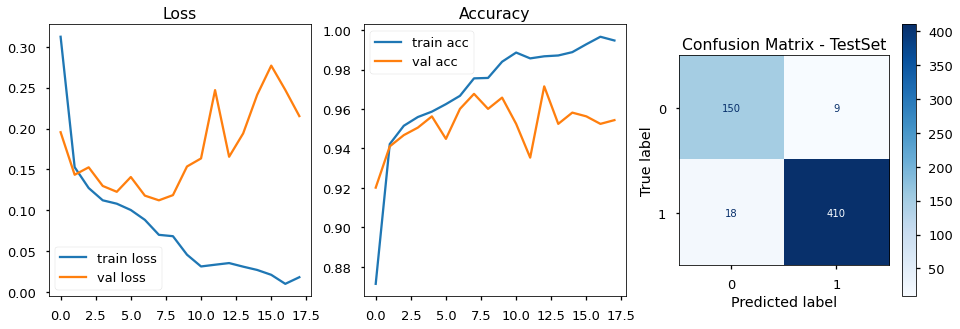

In [49]:
visualize_model_performance(Deeper_CNN, train_image, test_image, "acc", "val_acc")

* Using a deeper CNN overall accuracy is at 95% on the test set.
* Recall for pneumonia is high at 96%. Only 18 out of 428 pneumonia cases are mislabeled as normal. 
* Recall for Normal is high at 94%. only 9 out of 159 was mislabeled. 
* The model does not seem to overfit a much, but let's still experiment with some regularization techniques:

# CNN with dropout regularization:
* Dropout regularization helps prevent neural networks from overfitting. Dropout works by randomly disabling neurons and their corresponding connections. This prevents the network from relying too much on single neurons and forces all neurons to learn to generalize better.

In [50]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [86]:
model = Sequential()

# 1st Convolution and Pooling and dropout
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  #input_shape=(128, 128,1)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.4)) # regularization, turn off 40% of the neurons

# 2nd Convolution and Pooling
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.4)) # regularization

# 3rd Convolution and Pooling
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.4)) # regularization

# Flatten
model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128)) # inner layer
model.add(Dropout(0.2)) # regularization
model.add(Dense(activation = 'relu', units = 64)) # inner layer
model.add(Dropout(0.2)) # regularization
model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

model.save("Dropout_CNN")

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

model.summary()

INFO:tensorflow:Assets written to: Dropout_CNN/assets
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________

In [87]:
Dropout_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data=(val_image, y_val), callbacks = [early_stop] )

Epoch 1/100
153/153 [==============================] - 49s 320ms/step - loss: 0.5609 - acc: 0.7457 - val_loss: 0.3215 - val_acc: 0.8726
Epoch 2/100
153/153 [==============================] - 51s 335ms/step - loss: 0.2646 - acc: 0.8908 - val_loss: 0.2333 - val_acc: 0.9068
Epoch 3/100
153/153 [==============================] - 52s 341ms/step - loss: 0.2178 - acc: 0.9222 - val_loss: 0.2197 - val_acc: 0.9144
Epoch 4/100
153/153 [==============================] - 49s 318ms/step - loss: 0.1943 - acc: 0.9268 - val_loss: 0.1952 - val_acc: 0.9354
Epoch 5/100
153/153 [==============================] - 52s 339ms/step - loss: 0.1624 - acc: 0.9399 - val_loss: 0.1546 - val_acc: 0.9354
Epoch 6/100
153/153 [==============================] - 52s 342ms/step - loss: 0.1503 - acc: 0.9452 - val_loss: 0.1608 - val_acc: 0.9392
Epoch 7/100
153/153 [==============================] - 53s 345ms/step - loss: 0.1602 - acc: 0.9416 - val_loss: 0.1654 - val_acc: 0.9354
Epoch 8/100
153/153 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       159
           1       0.97      0.97      0.97       428

    accuracy                           0.96       587
   macro avg       0.95      0.95      0.95       587
weighted avg       0.96      0.96      0.96       587



19/19 [==============================] - 2s 81ms/step - loss: 0.1261 - acc: 0.9608
--------------------------
Final Train Loss: 0.0416
Final Test Loss: 0.1261
--------------------------
Final Train Acc: 0.9857
Final Test Acc: 0.9608




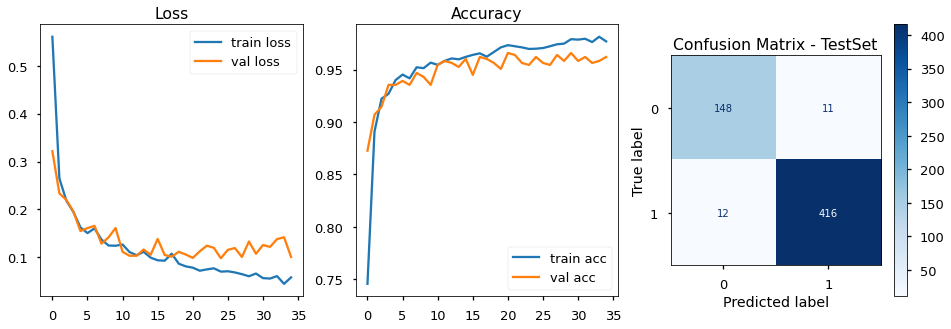

In [88]:
visualize_model_performance(Dropout_CNN, train_image, test_image, "acc", "val_acc")

* Using a deeper CNN with dropout regularization the overall accuracy is slightly higher: 96% on the test set.
* Recall for pneumonia is at 97%. 12 out of 428 pneumonia cases are mislabeled as normal. 
* Recall for pneumonia is at 93%., 11 out of 159 was mislabeled. 

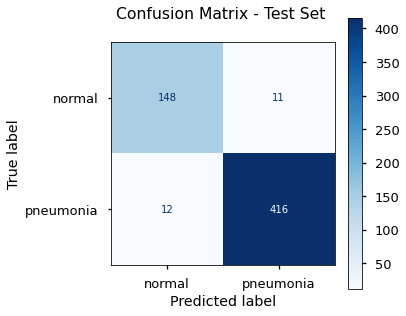

In [90]:
# Diplay seperately for the powerpoint:
with plt.style.context('seaborn-talk'):
        
    fig, ax1 = plt.subplots(figsize=(5,5))

    # Output (probability) predictions for the test set 
    y_hat_test = Dropout_CNN.model.predict(test_image)
    y_pred = np.rint(y_hat_test).astype(np.int) # Round elements of the array to the nearest integer.
    y_true = y_test.astype(np.int)
    
    # Generate a confusion matrix displaying the predictive accuracy of the model on the test set:
    cm = confusion_matrix(y_true, y_pred) # normalize = 'true'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 
                                                                      'pneumonia'])
    disp.plot(cmap = "Blues", ax=ax1)
    ax1.set_title('Confusion Matrix - Test Set \n')
plt.savefig('./images/Dropout_CNN_confusionmatrix', dpi=300, bbox_inches='tight')  

# CNN with dropout and class weights:

In [54]:
Weighted_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data=(val_image, y_val), 
                         callbacks = [early_stop], class_weight = weights_dict)

Epoch 1/100
153/153 [==============================] - 48s 315ms/step - loss: 0.0336 - acc: 0.9705 - val_loss: 0.1232 - val_acc: 0.9563
Epoch 2/100
153/153 [==============================] - 47s 308ms/step - loss: 0.0303 - acc: 0.9732 - val_loss: 0.1621 - val_acc: 0.9487
Epoch 3/100
153/153 [==============================] - 47s 305ms/step - loss: 0.0288 - acc: 0.9747 - val_loss: 0.1233 - val_acc: 0.9620
Epoch 4/100
153/153 [==============================] - 47s 306ms/step - loss: 0.0311 - acc: 0.9715 - val_loss: 0.1526 - val_acc: 0.9506
Epoch 5/100
153/153 [==============================] - 47s 308ms/step - loss: 0.0334 - acc: 0.9730 - val_loss: 0.1400 - val_acc: 0.9506
Epoch 6/100
153/153 [==============================] - 47s 308ms/step - loss: 0.0282 - acc: 0.9747 - val_loss: 0.1414 - val_acc: 0.9525
Epoch 7/100
153/153 [==============================] - 50s 326ms/step - loss: 0.0319 - acc: 0.9726 - val_loss: 0.1462 - val_acc: 0.9487
Epoch 8/100
153/153 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       159
           1       0.99      0.96      0.97       428

    accuracy                           0.96       587
   macro avg       0.94      0.96      0.95       587
weighted avg       0.96      0.96      0.96       587



19/19 [==============================] - 1s 62ms/step - loss: 0.1168 - acc: 0.9608
--------------------------
Final Train Loss: 0.0615
Final Test Loss: 0.1168
--------------------------
Final Train Acc: 0.9806
Final Test Acc: 0.9608




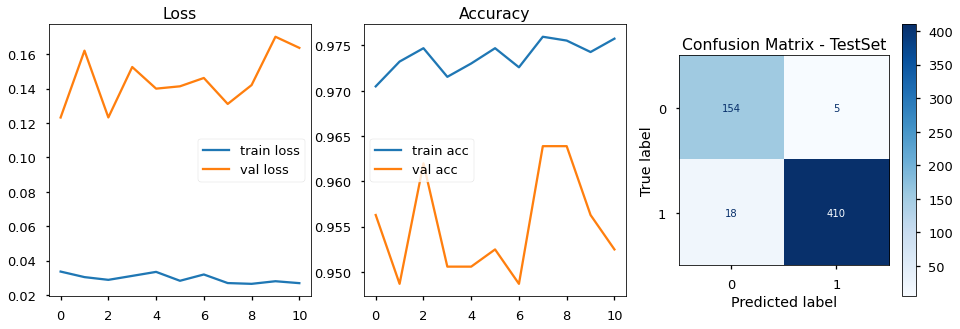

In [55]:
visualize_model_performance(Weighted_CNN, train_image, test_image, "acc", "val_acc")

* Adding class weights made the recall value for pneumonue a bit worse by increasing the weight for normal cases. Since we care about detecting true positives - pneumonia we will not use class weights. 

# CNN with L2 regularization:
* L2 regularization is also known as weight decay as it forces the weights to decay towards zero (but not exactly zero).
* L2 regularization combats overfitting by forcing weights to be small.

In [56]:
model = Sequential()

# 1st Convolution and Pooling and dropout
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=regularizers.l2(0.005))) 
model.add(MaxPool2D(pool_size = (2, 2)))

# 2nd Convolution and Pooling
model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.005))) # default is 0.01
model.add(MaxPool2D(pool_size = (2, 2)))

# 3rd Convolution and Pooling
model.add(Conv2D(128, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.005)))
model.add(MaxPool2D(pool_size = (2, 2)))

# Flatten
model.add(Flatten())

# Add dense layers
model.add(Dense(activation = 'relu', units = 128, kernel_regularizer=regularizers.l2(0.005))) # inner layer
model.add(Dense(activation = 'relu', units = 64, kernel_regularizer=regularizers.l2(0.005))) # inner layer
model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)            

In [57]:
L2_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data=(val_image, y_val), callbacks = [early_stop])

Epoch 1/100
153/153 [==============================] - 44s 291ms/step - loss: 0.8621 - acc: 0.8503 - val_loss: 0.4590 - val_acc: 0.9068
Epoch 2/100
153/153 [==============================] - 45s 295ms/step - loss: 0.3729 - acc: 0.9327 - val_loss: 0.3464 - val_acc: 0.9354
Epoch 3/100
153/153 [==============================] - 44s 289ms/step - loss: 0.3129 - acc: 0.9374 - val_loss: 0.2923 - val_acc: 0.9297
Epoch 4/100
153/153 [==============================] - 44s 288ms/step - loss: 0.2707 - acc: 0.9460 - val_loss: 0.2645 - val_acc: 0.9468
Epoch 5/100
153/153 [==============================] - 44s 289ms/step - loss: 0.2681 - acc: 0.9441 - val_loss: 0.2704 - val_acc: 0.9487
Epoch 6/100
153/153 [==============================] - 44s 288ms/step - loss: 0.2697 - acc: 0.9429 - val_loss: 0.2374 - val_acc: 0.9449
Epoch 7/100
153/153 [==============================] - 44s 287ms/step - loss: 0.2300 - acc: 0.9521 - val_loss: 0.2427 - val_acc: 0.9354
Epoch 8/100
153/153 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       159
           1       0.96      0.95      0.96       428

    accuracy                           0.94       587
   macro avg       0.92      0.93      0.92       587
weighted avg       0.94      0.94      0.94       587



19/19 [==============================] - 1s 73ms/step - loss: 0.1978 - acc: 0.9370
--------------------------
Final Train Loss: 0.1357
Final Test Loss: 0.1978
--------------------------
Final Train Acc: 0.9726
Final Test Acc: 0.937




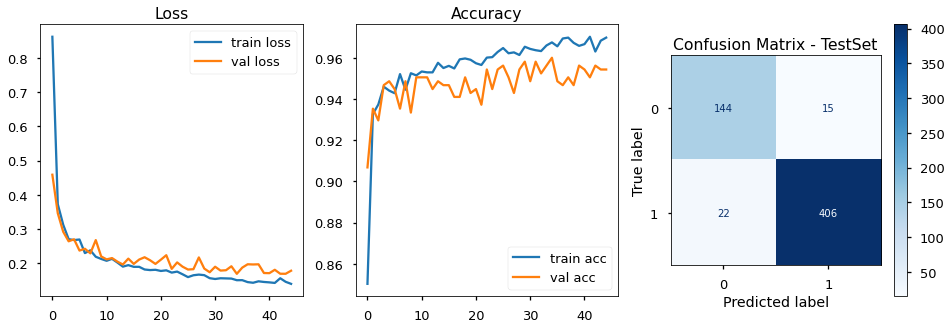

In [58]:
visualize_model_performance(L2_CNN, train_image, test_image, "acc", "val_acc")

* Using a deeper CNN with L2 regularization (instead of dropout) achieves similar but slightly worse results:
* The overall accuracy is: 94% on the test set.
* Recall for pneumonia is 95%. 22 out of 428 pneumonia cases are mislabeled as normal. 
* 15 out of 159 normal cases were mislabeled. 

# CNN with dropout and L2 regularization:

In [59]:
model = Sequential()

# 1st Convolution and Pooling and dropout
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  #input_shape=(128, 128,1)
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.4)) # regularization


# 2nd Convolution and Pooling
model.add(Conv2D(64, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.005))) # default is 0.01
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.4)) # regularization

# 3rd Convolution and Pooling
model.add(Conv2D(128, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.005)))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.4)) # regularization

# Flatten
model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128, kernel_regularizer=regularizers.l2(0.005))) # inner layer
model.add(Dropout(0.2)) # regularization

model.add(Dense(activation = 'relu', units = 64, kernel_regularizer=regularizers.l2(0.005))) # inner layer
model.add(Dropout(0.2)) # regularization

model.add(Dense(activation = 'sigmoid', units = 1)) # output layer

model.save("Dropout_L2_CNN")

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

model.summary()

INFO:tensorflow:Assets written to: Dropout_L2_CNN/assets
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 30, 64)        0         
_______________________________________________________________

In [60]:
Dropout_L2_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data=(val_image, y_val), callbacks = [early_stop])

Epoch 1/100
153/153 [==============================] - 53s 344ms/step - loss: 1.4044 - acc: 0.7499 - val_loss: 0.8373 - val_acc: 0.8897
Epoch 2/100
153/153 [==============================] - 50s 329ms/step - loss: 0.5171 - acc: 0.8832 - val_loss: 0.4425 - val_acc: 0.9144
Epoch 3/100
153/153 [==============================] - 59s 386ms/step - loss: 0.4122 - acc: 0.9011 - val_loss: 0.3638 - val_acc: 0.9278
Epoch 4/100
153/153 [==============================] - 55s 362ms/step - loss: 0.3719 - acc: 0.9102 - val_loss: 0.3713 - val_acc: 0.9221
Epoch 5/100
153/153 [==============================] - 54s 351ms/step - loss: 0.3509 - acc: 0.9114 - val_loss: 0.3118 - val_acc: 0.9278
Epoch 6/100
153/153 [==============================] - 53s 347ms/step - loss: 0.3159 - acc: 0.9273 - val_loss: 0.3160 - val_acc: 0.9278
Epoch 7/100
153/153 [==============================] - 53s 349ms/step - loss: 0.3036 - acc: 0.9313 - val_loss: 0.3573 - val_acc: 0.9240
Epoch 8/100
153/153 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       159
           1       0.96      0.97      0.97       428

    accuracy                           0.95       587
   macro avg       0.95      0.94      0.94       587
weighted avg       0.95      0.95      0.95       587



19/19 [==============================] - 1s 64ms/step - loss: 0.1926 - acc: 0.9540
--------------------------
Final Train Loss: 0.1716
Final Test Loss: 0.1926
--------------------------
Final Train Acc: 0.9688
Final Test Acc: 0.954




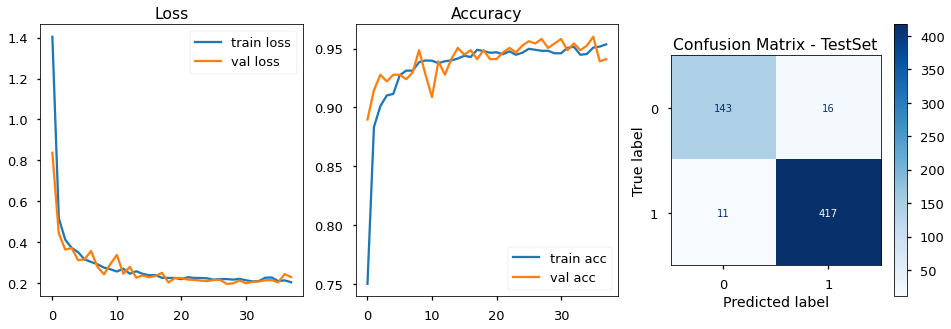

In [61]:
visualize_model_performance(Dropout_L2_CNN, train_image, test_image, "acc", "val_acc")

* Using a deeper CNN with dropout as well as L2 acheives similar results.
* Recall for pneumonia is still high with 97%. Only 11 out of 428 pneumonia cases are mislabeled as normal. 

# CNN with dropout and lower learning rate:
* One of the key hyperparameters to set in order to train a neural network is the learning rate for gradient descent. This parameter scales the magnitude of our weight updates in order to minimize the network's loss function.
* If your learning rate is set too low, training will progress very slowly as you are making very tiny updates to the weights in your network. However, if your learning rate is set too high, it can cause undesirable divergent behavior in your loss function. 

In [62]:
model = keras.models.load_model("Dropout_CNN")

In [68]:
optm = optimizers.Adam(learning_rate=0.0005) # default is 0.001
 
model.compile(optimizer = optm, loss = 'binary_crossentropy', metrics = ['acc'])

Dropout_LowLR_CNN = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data=(val_image, y_val), 
                         callbacks = [early_stop])

Epoch 1/100
153/153 [==============================] - 51s 333ms/step - loss: 0.0490 - acc: 0.9804 - val_loss: 0.1452 - val_acc: 0.9506
Epoch 2/100
153/153 [==============================] - 55s 360ms/step - loss: 0.0508 - acc: 0.9800 - val_loss: 0.1349 - val_acc: 0.9563
Epoch 3/100
153/153 [==============================] - 52s 343ms/step - loss: 0.0433 - acc: 0.9831 - val_loss: 0.1486 - val_acc: 0.9582
Epoch 4/100
153/153 [==============================] - 52s 342ms/step - loss: 0.0417 - acc: 0.9848 - val_loss: 0.1287 - val_acc: 0.9601
Epoch 5/100
153/153 [==============================] - 54s 355ms/step - loss: 0.0445 - acc: 0.9831 - val_loss: 0.1081 - val_acc: 0.9620
Epoch 6/100
153/153 [==============================] - 53s 348ms/step - loss: 0.0429 - acc: 0.9829 - val_loss: 0.1356 - val_acc: 0.9658
Epoch 7/100
153/153 [==============================] - 54s 355ms/step - loss: 0.0389 - acc: 0.9855 - val_loss: 0.1607 - val_acc: 0.9468
Epoch 8/100
153/153 [===========================

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       159
           1       0.98      0.97      0.97       428

    accuracy                           0.96       587
   macro avg       0.95      0.96      0.95       587
weighted avg       0.96      0.96      0.96       587



19/19 [==============================] - 1s 66ms/step - loss: 0.1125 - acc: 0.9625
--------------------------
Final Train Loss: 0.0286
Final Test Loss: 0.1125
--------------------------
Final Train Acc: 0.9928
Final Test Acc: 0.9625




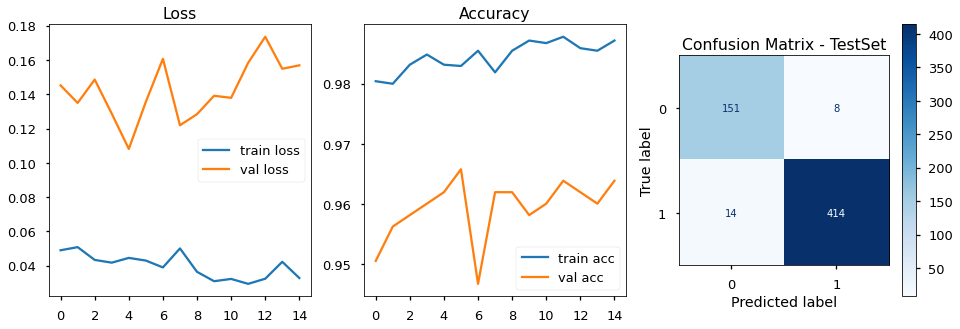

In [89]:
visualize_model_performance(Dropout_LowLR_CNN, train_image, test_image, "acc", "val_acc")

* Adding a lower learning rate to dropout regularization slightly improved the predictions for the normal class, but pneumonia prediction got slightly worse. 

# Transfer Learning with VGG19:

* Transfer learning (TL) focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks. (Source: https://en.wikipedia.org/wiki/Transfer_learning)

* It is quite popular in deep learning where pre-trained models are used as the starting point on Computer Vision (CV) tasks. This way one can get the benefit of using complex models developed by others as start point and on top of it build more.

### Adjustments to default VGG19:

* Use the weights as it was in original model, so we set weights = 'imagenet'
* Change the image size from the input layer so we can use the model on our images: (128, 128, 3)
* Remove the top layers by setting: include_top=False to include your own fully connected layers with adjusted neuron parameters. 
* Add a final layer with a binary classification output. 
* We will not train the default model layers. We will only train the final added layers. So, we will set properties for trainable = False. 

### The default VGG19 model:

In [70]:
from tensorflow.keras.applications import VGG19

In [71]:
# the default VGG16 model
VGG19().summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Create the base VGG19 model:

In [72]:
base_model = VGG19(include_top = False, weights = "imagenet", input_shape = (128, 128, 3))
# all the layers intrainable - freeze the layers (except last ones we will be adding)
base_model.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

### Create the full VGG19 model:

In [73]:
model = Sequential()
model.add(base_model)
model.add(Flatten())

# Add the fully connected layers
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.4)) # regularization
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.4)) # regularization
model.add(Dense(1, activation = "sigmoid"))

# You could freeze layers here too:
# for layer in base_model.layers[:-1]:  # or for layer in base_model.layers:
# layer.trainable = False

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               1048704   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                

In [74]:
# Compile model, select loss function and optimizer to use
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [75]:
# Fit model
VGG19 = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data=(val_image, y_val), 
                         callbacks = [early_stop])

Epoch 1/100
153/153 [==============================] - 307s 2s/step - loss: 0.2812 - accuracy: 0.8880 - val_loss: 0.1727 - val_accuracy: 0.9354
Epoch 2/100
153/153 [==============================] - 302s 2s/step - loss: 0.1836 - accuracy: 0.9304 - val_loss: 0.1563 - val_accuracy: 0.9373
Epoch 3/100
153/153 [==============================] - 299s 2s/step - loss: 0.1649 - accuracy: 0.9355 - val_loss: 0.1757 - val_accuracy: 0.9297
Epoch 4/100
153/153 [==============================] - 298s 2s/step - loss: 0.1460 - accuracy: 0.9511 - val_loss: 0.1197 - val_accuracy: 0.9582
Epoch 5/100
153/153 [==============================] - 296s 2s/step - loss: 0.1311 - accuracy: 0.9540 - val_loss: 0.1080 - val_accuracy: 0.9525
Epoch 6/100
153/153 [==============================] - 294s 2s/step - loss: 0.1363 - accuracy: 0.9530 - val_loss: 0.1150 - val_accuracy: 0.9487
Epoch 7/100
153/153 [==============================] - 294s 2s/step - loss: 0.1277 - accuracy: 0.9545 - val_loss: 0.1307 - val_accuracy:

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       159
           1       0.98      0.96      0.97       428

    accuracy                           0.96       587
   macro avg       0.94      0.96      0.95       587
weighted avg       0.96      0.96      0.96       587



19/19 [==============================] - 31s 2s/step - loss: 0.0953 - accuracy: 0.9591
--------------------------
Final Train Loss: 0.0744
Final Test Loss: 0.0953
--------------------------
Final Train Acc: 0.9728
Final Test Acc: 0.9591




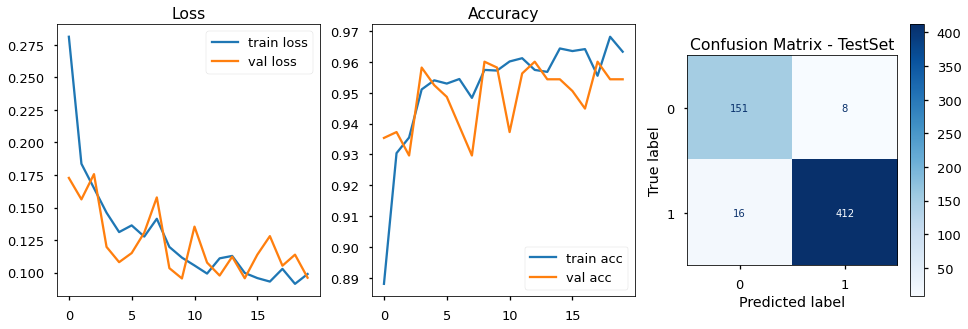

In [76]:
visualize_model_performance(VGG19, train_image, test_image, "accuracy", "val_accuracy")

* Using transfer learning with VGG19 we get very similar results.
* Overall accuracy is 96% on the test set.
* Recall for pneumonia is high with 96%. 16 out of 428 pneumonia cases are mislabeled as normal. 
* Recall for normal is high with 95%. 8 out of 159 was mislabeled. 

# Transfer Learning with RESNET50V2:

### Default RESNET50V2:

In [79]:
# the default VGG16 model
from keras.applications.resnet_v2 import ResNet50V2
ResNet50V2().summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

### Adjustments to default RESNET50:

* Use the weights as it was in original model, so we set weights = 'imagenet'
* Change the image size from the input layer so we can use the model on our images: (128, 128, 3)
* Remove the top layers by setting: include_top=False
* Add a final layer with a binary classification output. 
* We will not train the default model layers. We will only train the final added layers. So, we will set properties for trainable = False. 
* add a global pooling layer = 'avg' rather than flattening the image. 

In [80]:
base_model = keras.applications.ResNet50V2(weights = "imagenet",
                                            input_shape = (128, 128, 3),
                                            pooling="avg", include_top = False,
                                            classes = 2)

base_model.trainable = False
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [81]:
model = Sequential()
model.add(base_model)

# Add the fully connected layers
model.add(Dense(1, activation = "sigmoid"))

model.summary()
model.save("RESNET50V2");

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________
INFO:tensorflow:Assets written to: RESNET50V2/assets


In [82]:
# Compile model
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [83]:
# Fit model
RESNET50V2 = model.fit(train_image, y_train, epochs = 100, batch_size=31,
                    validation_data=(val_image, y_val), 
                         callbacks = [early_stop])

Epoch 1/100
153/153 [==============================] - 95s 622ms/step - loss: 0.2899 - accuracy: 0.8851 - val_loss: 0.1692 - val_accuracy: 0.9240
Epoch 2/100
153/153 [==============================] - 94s 615ms/step - loss: 0.1617 - accuracy: 0.9403 - val_loss: 0.1422 - val_accuracy: 0.9430
Epoch 3/100
153/153 [==============================] - 84s 548ms/step - loss: 0.1399 - accuracy: 0.9467 - val_loss: 0.1336 - val_accuracy: 0.9487
Epoch 4/100
153/153 [==============================] - 89s 581ms/step - loss: 0.1252 - accuracy: 0.9532 - val_loss: 0.1324 - val_accuracy: 0.9601
Epoch 5/100
153/153 [==============================] - 97s 634ms/step - loss: 0.1106 - accuracy: 0.9576 - val_loss: 0.1234 - val_accuracy: 0.9639
Epoch 6/100
153/153 [==============================] - 91s 595ms/step - loss: 0.1062 - accuracy: 0.9637 - val_loss: 0.1210 - val_accuracy: 0.9601
Epoch 7/100
153/153 [==============================] - 90s 588ms/step - loss: 0.1008 - accuracy: 0.9633 - val_loss: 0.1259 -

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       159
           1       0.97      0.98      0.98       428

    accuracy                           0.96       587
   macro avg       0.96      0.95      0.95       587
weighted avg       0.96      0.96      0.96       587



19/19 [==============================] - 9s 496ms/step - loss: 0.0969 - accuracy: 0.9642
--------------------------
Final Train Loss: 0.0746
Final Test Loss: 0.0969
--------------------------
Final Train Acc: 0.977
Final Test Acc: 0.9642




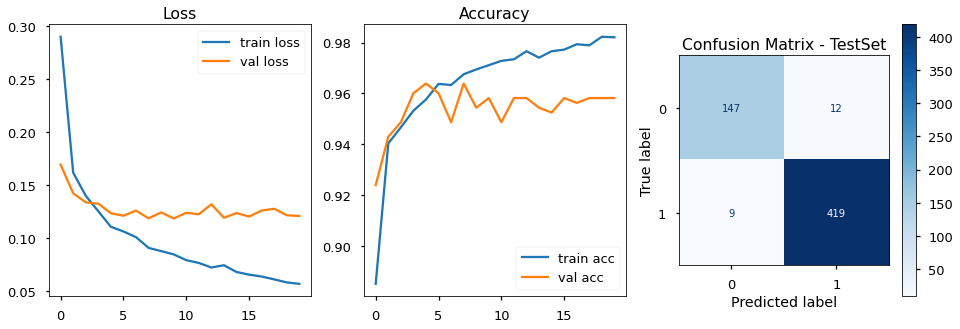

In [84]:
visualize_model_performance(RESNET50V2, train_image, test_image, "accuracy", "val_accuracy")

* Using transfet learning with RESNET5V2 we get very good results.
* Overall accuracy is 96% on the test set.
* Recall for pneumonia is high with 98%. Only 9 out of 428 pneumonia cases are mislabeled as normal. 
* Recall for normal is at 92%. 12 out of 159 was mislabeled. 

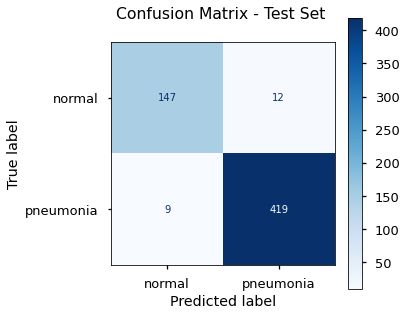

In [96]:
# Diplay seperately for the powerpoint:
with plt.style.context('seaborn-talk'):
        
    fig, ax1 = plt.subplots(figsize=(5,5))

    # Output (probability) predictions for the test set 
    y_hat_test = RESNET50V2.model.predict(test_image)
    y_pred = np.rint(y_hat_test).astype(np.int) # Round elements of the array to the nearest integer.
    y_true = y_test.astype(np.int)
    
    # Generate a confusion matrix displaying the predictive accuracy of the model on the test set:
    cm = confusion_matrix(y_true, y_pred) # normalize = 'true'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 
                                                                      'pneumonia'])
    disp.plot(cmap = "Blues", ax=ax1)
    ax1.set_title('Confusion Matrix - Test Set \n')
plt.savefig('./images/RESNET50V2_confusionmatrix', dpi=300, bbox_inches='tight')  

#  Best Performing Model?


In [91]:
train_acc_Dropout_CNN = np.round(Dropout_CNN.model.evaluate(train_image, y_train)[1],3)
val_acc_Dropout_CNN = np.round(Dropout_CNN.model.evaluate(val_image, y_val)[1],3)

train_acc_VGG19 = np.round(VGG19.model.evaluate(train_image, y_train)[1],3)
val_acc_VGG19 = np.round(VGG19.model.evaluate(val_image, y_val)[1],3)

train_acc_RESNET50V2 = np.round(RESNET50V2.model.evaluate(train_image, y_train)[1],3)
val_acc_RESNET50V2 = np.round(RESNET50V2.model.evaluate(val_image, y_val)[1],3)


17/17 [==============================] - 7s 434ms/step - loss: 0.1185 - accuracy: 0.9582


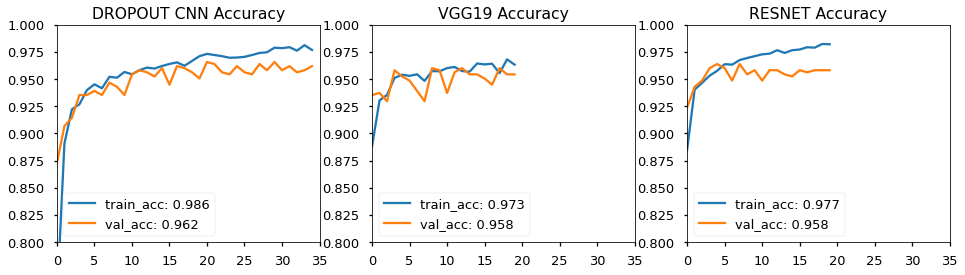

In [94]:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))  
    
    ax1.plot(Dropout_CNN.history['acc'])
    ax1.plot(Dropout_CNN.history['val_acc'])
    ax1.set_title('DROPOUT CNN Accuracy')
    ax1.legend(labels = [f'train_acc: {train_acc_Dropout_CNN}', f'val_acc: {val_acc_Dropout_CNN}'])
    ax1.set_ylim([0.80, 1])
    ax1.set_xlim([0, 35])
    
    ax2.plot(VGG19.history['accuracy'])
    ax2.plot(VGG19.history['val_accuracy'])
    ax2.set_title('VGG19 Accuracy')
    ax2.legend(labels = [f'train_acc: {train_acc_VGG19}', f'val_acc: {val_acc_VGG19}'])
    ax2.set_ylim([0.80, 1])
    ax2.set_xlim([0, 35])
    
    ax3.plot(RESNET50V2.history['accuracy'])
    ax3.plot(RESNET50V2.history['val_accuracy'])
    ax3.set_title('RESNET Accuracy')
    ax3.legend(labels = [f'train_acc: {train_acc_RESNET50V2}', f'val_acc: {val_acc_RESNET50V2}'])
    ax3.set_ylim([0.80, 1])
    ax3.set_xlim([0, 35])
    
plt.savefig('./images/CompareModels_train_val_acc', dpi=300, bbox_inches='tight')


* All CNN models performed similarly well with no apparent signs of overfitting as seen by the loss and accuracy trends for the training and validation sets

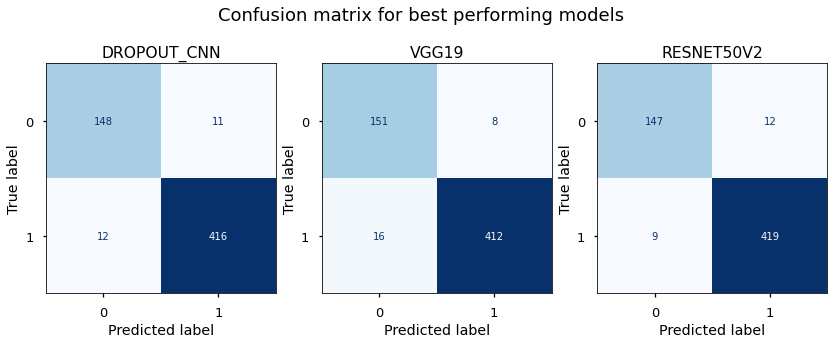

In [95]:
with plt.style.context('seaborn-talk'):
 
    fig, axs = plt.subplots(1, 3, figsize=(14,5))
    fig.suptitle("Confusion matrix for best performing models \n", fontsize=18)
    
    for ax, result, modelname in zip(axs.ravel(),[Dropout_CNN, VGG19, RESNET50V2],['DROPOUT_CNN', 'VGG19', 'RESNET50V2']):
        y_hat_test = result.model.predict(test_image)
        y_pred = np.rint(y_hat_test).astype(np.int) 
        y_true = y_test.astype(np.int)
        cm = confusion_matrix(y_true, y_pred) # normalize = 'true'
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap = "Blues", ax=ax, colorbar =False)
        ax.set_title(modelname) 
plt.savefig('./images/CompareModels_ConfusionMatrices', dpi=300, bbox_inches='tight')
        

* All models reached overall accuracy levels of 95-96% and recall values of 97-98% for the pneumonia cases for the tets set.  

* **RESNET50V2** was chosen as the final model since it gave the best performance on test dataset by missing only 9 pneumonia-positive cases out of 428, and 12 out of 159 normal cases. Dropout CNN gave similar predictions despite being way simpler. 

* Using RESNET50V2 results on the test set were:
    - overall accuracy score of 96%, 
    - recall score of 92% for class normal, and 98% for class pneumonia 
    - f1 score of 93% for class normal, and 98% for class pneumonia

# Visualize Intermediate Activations:

In [97]:
# load drop out CNN architecture
best_model = keras.models.load_model("Dropout_CNN")
best_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 128)     

### Load a sample Image, Transform the Image to a Tensor and Visualize:

In [98]:
# List the file names to pick one
os.listdir("Data/OUTPUT/train/PNEUMONIA")[0:15]

['person63_bacteria_306.jpeg',
 'person1438_bacteria_3721.jpeg',
 'person478_virus_975.jpeg',
 'person661_bacteria_2553.jpeg',
 'person1214_bacteria_3166.jpeg',
 'person1353_virus_2333.jpeg',
 'person26_bacteria_122.jpeg',
 'person1619_bacteria_4261.jpeg',
 'person890_bacteria_2814.jpeg',
 'person147_bacteria_706.jpeg',
 'person1491_bacteria_3893.jpeg',
 'person69_bacteria_338.jpeg',
 'person100_bacteria_482.jpeg',
 'person321_bacteria_1489.jpeg',
 'person281_bacteria_1329.jpeg']

(1, 128, 128, 3)


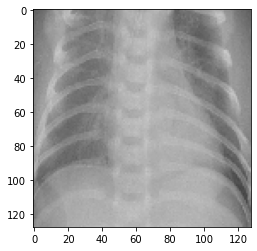

In [113]:
# preview a sample image - we will use this image to display feature maps:
filename = 'Data/chest_xray/train/PNEUMONIA/person69_bacteria_338.jpeg'
img = image.load_img(filename, target_size=(128, 128))
img_tensor = image.img_to_array(img)

# reshape the image into tensor to be able to use with the CNN architecture:
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

# Check tensor shape
print(img_tensor.shape)

# Preview the image
plt.imshow(img_tensor[0])
plt.show()

### Plot Feature Maps:
* The idea of visualizing a feature map for a specific input image would be to understand what features of the input are detected or preserved in the feature maps.
* Specifically, the models are comprised of small linear filters and the result of applying filters called activation maps / feature maps. Visualize all 32 of the channels / filters from the first activation function.
* We can also visualize a single channel / filter across each of the feature maps / activation layers. Representations learned by CNN architectures become increasingly more abstract with the depth of the layers. 


### Visualize all 32 of the channels from the first activation function.
* The initial three layers output feature maps that have 32 channels each. 

In [114]:
# Extract the feature maps, or layer outputs from each of the activation functions in the model. 
layer_outputs = [layer.output for layer in best_model.layers[:8]]

# Generate models that transform the image from its raw state to these feature map
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs)

#  Take these transformations and visualize each channel for each feature map. Returns an array for each activation layer
activations = activation_model.predict(img_tensor)

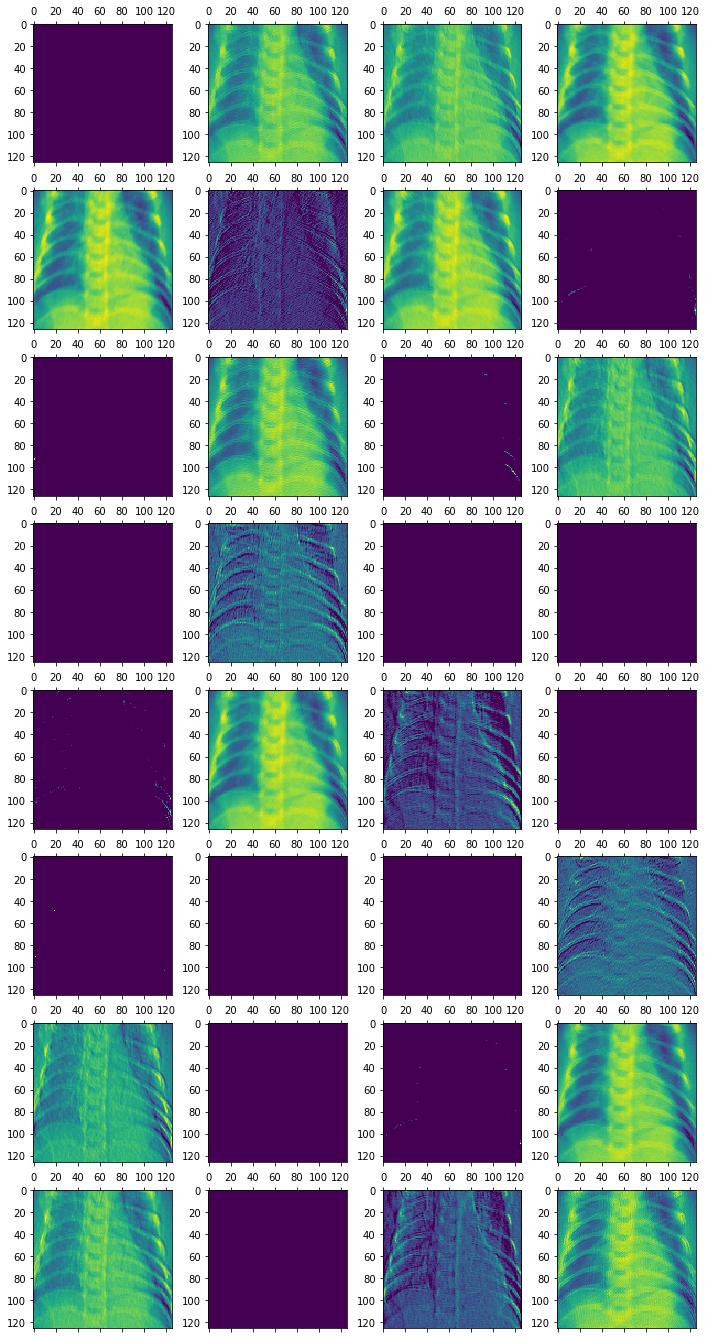

In [115]:
# Visualize all 32 of the channels from the first activation function:

fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0] # first activation channel
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis') 
# In the case of the blank images displayed, this indicates that the patterns were not present in the current image.

### Visualize a single channel for each of the activation layers:
* Below is the visualization of the 25th channel for each of the activation layers. (Recall that there are more channels in later layers.)

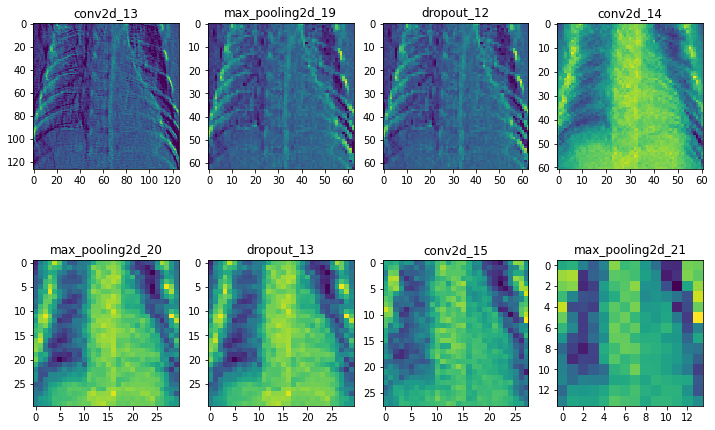

In [117]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in best_model.layers[:8]:  # layers until the 8th layer
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :,30])
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])
    
plt.savefig('./images/ActivationChannels', dpi=300, bbox_inches='tight')    

* Deeper layers are more abstract representations. This demonstrates how the representations learned by CNN architectures become increasingly abstract with the depth of the layers. 
* The expectation would be that the feature maps close to the input detect small or fine-grained detail, whereas feature maps close to the output of the model capture more general features.

###  Visualize each of the channels for each of feature maps of the convolutional layers:
* Code taken from https://github.com/learn-co-curriculum/dsc-visualizing-activation-functions-lab/tree/solution

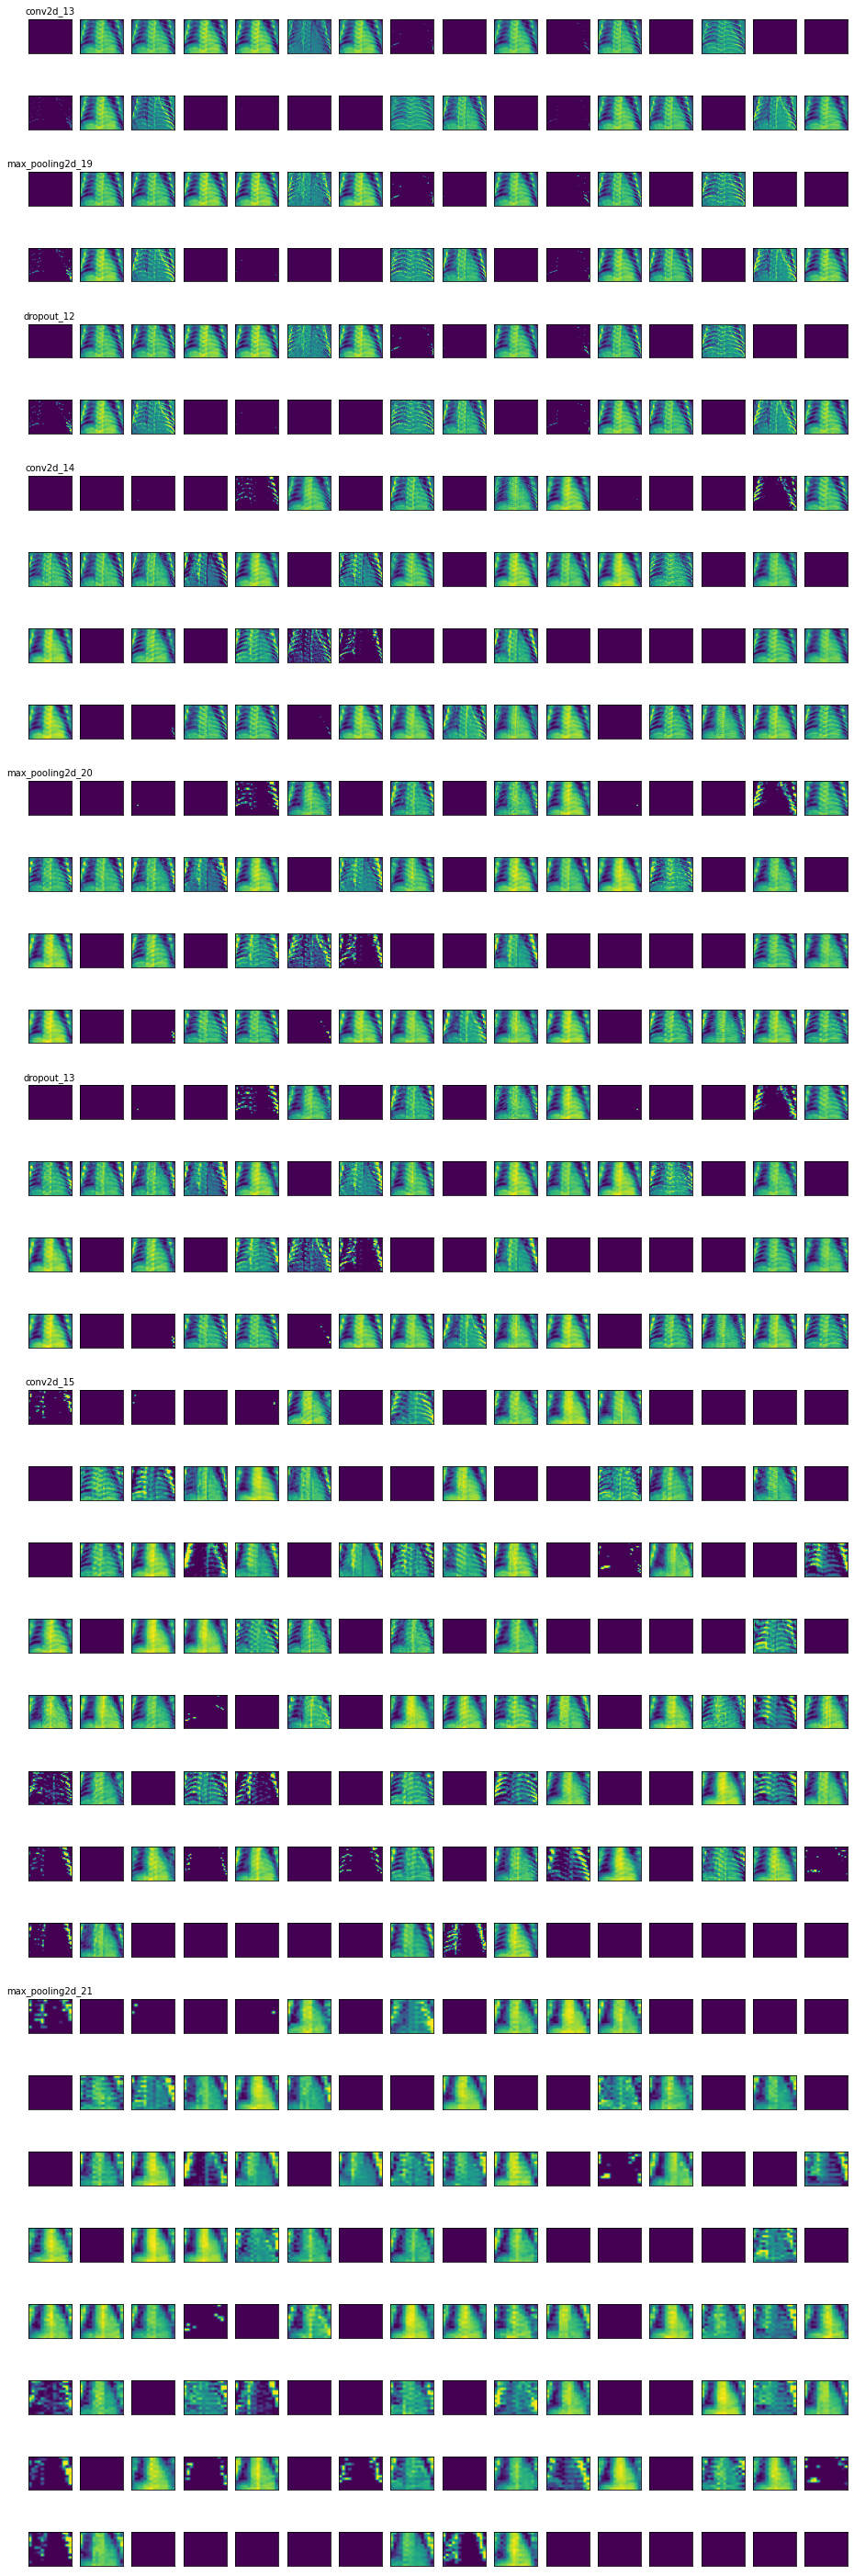

In [118]:
from keras import models
import math 

# Extract model layer outputs
layer_outputs = [layer.output for layer in best_model.layers[:8]]

# Create a model for displaying the feature maps
activation_model = models.Model(inputs=best_model.input, outputs=layer_outputs)

activations = activation_model.predict(img_tensor)

# Extract Layer Names for Labelling
layer_names = []
for layer in best_model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.show()


## Recommendations

* Neural network may be used to aid the healthcare professional in stream-lining the diagnosing process when classifying x-ray images. This may allow for a quicker return time and greater patient satisfaction. 

* Catching as many people with pneumonia as possible is particularly important for early intervention. Use of ANN for image classification might lead to more positive outcomes because the positive patients can begin treatment right away as opposed to waiting lenghty periods of time until they hear from the readings of the radiologist and interpretation of the doctor. 

* Such process would also reduce any radiologist's/doctor's stress at having to look through a great deal of images. They could instead use their time to more rigorously go over the images that fall more into the grey zone based on the model predictions. 

* Less time the doctors expend looking at images to arrive at a diagnosis, the more time they can allocate to dealing with more demanding and complex procedures.


## Limitations and Next Steps

* We can use data augmentation methods to increase the size of the training data set which could improve model performance on unseen data. 
* We can crop the images to exclude the electrodes and the R script from the display which negatively affect the image processing algorithm. 
* We could address the class imbalance issue using oversampling techniques which could again improve performance.

**Exporting to PDF using nbconvert**:
1. install nbconvert: ! pip install nbconvert
2. install MacTeX from tps://tug.org/mactex/
3. ! export PATH=/Library/TeX/texbin:$PATH
4. ! jupyter nbconvert --to PDF NOTEBOOKNAME.ipynb

In [119]:
! export PATH=/Library/TeX/texbin:$PATH

In [120]:
! jupyter nbconvert --to PDF Notebook.ipynb

[NbConvertApp] Converting notebook Notebook.ipynb to PDF
[NbConvertApp] Writing 2062329 bytes to Notebook.pdf
